In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from tabulate import tabulate

import os
import glob
import json
import shutil
import re

from PIL import Image, ImageDraw

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'pandas'

## Loading the images to create facial embeddings

In [ ]:
class Config:
    def __init__(self):
        self.image_width = 128
        self.image_height = 128
        self.epoch = 5
        self.seed = 42
        self.batch_size = 64
        self.dataset_path = './DATASET'
        # self.checkpoint_filepath = 'model_checkpoint.h5'
        # self.logs_path = '/kaggle/working/logs'
        
config = Config()

In [ ]:
# If device is "cuda" then GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Device: {device}")

Device: cuda


Converting the dataset into a dataframe and also converting png files into jpg files for consistency

In [ ]:
dataset = {"image_path":[],"img_status":[],"where":[]}
pattern = re.compile(r'^(.*)\.png$')

for where in ['fake', 'real']:
    for status in os.listdir(config.dataset_path+"/"+where):
        for image in glob.glob(os.path.join(config.dataset_path, where, status)):

            match_obj = pattern.match(image)
            if match_obj:
                name_without_ext = match_obj.group(1)
                convert = Image.open(image).convert('RGB')
                jpg_path = name_without_ext + ".jpg"
                convert.save(jpg_path)
                image = jpg_path
                
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset.head(10)

,image_path,img_status,where
0,./DATASET/fake/person(100).jpg,person(100).jpg,fake
1,./DATASET/fake/person(98).jpg,person(98).jpg,fake
2,./DATASET/fake/person(87).jpg,person(87).jpg,fake
3,./DATASET/fake/person(62).jpg,person(62).jpg,fake
4,./DATASET/fake/person(92).jpg,person(92).jpg,fake
5,./DATASET/fake/person(63).jpg,person(63).jpg,fake
6,./DATASET/fake/person(69).jpg,person(69).jpg,fake
7,./DATASET/fake/person(81).jpg,person(81).jpg,fake
8,./DATASET/fake/person(51).jpg,person(51).jpg,fake
9,./DATASET/fake/person(56).jpg,person(56).jpg,fake


Here is the model architecture of the pre-trained model we are going to use to generate the facial embeddings. 

We'll create a function that returns the activations from the pen-ultimate layer so that we can get the facial embeddings.

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(CustomModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=True)
        
        if 'vgg' in model_name:
            num_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
            
        elif 'mobilenet' in model_name:
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        else:
            num_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        self.val_loss = []
        self.val_accuracy = []
        self.train_loss = []
        self.train_accuracy = []

    def forward(self, x):
        return self.model(x)

    def print_model_summary(self):
        print(self.model)
        print("Model Summary:")
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total Parameters: {total_params}")
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Trainable Parameters: {trainable_params}")

    def plot_metrics_graph(self):
        epochs = range(1, len(self.train_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.train_loss, label='Train Loss', linewidth=2, color='blue')
        plt.plot(epochs, self.val_loss, label='Validation Loss', linewidth=2, color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.train_accuracy, label='Train Accuracy', linewidth=2, color='green')
        plt.plot(epochs, self.val_accuracy, label='Validation Accuracy', linewidth=2, color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    def train_model(self, train_loader, valid_loader, num_epochs, device):
        criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
        optimizer = optim.Adam(self.parameters(), lr=0.001)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True, min_lr=1e-6)

        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            total_loss = 0.0
            correct_train = 0
            total_train = 0

            print(f"Epoch [{epoch+1}/{num_epochs}] - Training...")

            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                predicted_labels = (outputs >= 0.0).float()
                correct_train += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                total_train += labels.size(0)

                print(f"Epoch [{epoch+1}/{num_epochs}] - Batch [{batch_idx+1}/{len(train_loader)}] - "
                      f"Loss: {loss.item():.4f} - Train Accuracy: {correct_train / total_train:.4f}")

            average_loss = total_loss / len(train_loader.dataset)
            train_accuracy = correct_train / total_train

            self.train_loss.append(average_loss)
            self.train_accuracy.append(train_accuracy)

            self.eval()
            total_val_loss = 0.0
            correct_val = 0
            total_val = 0

            y_true = []
            y_pred = []

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels.float().unsqueeze(1))
                    total_val_loss += val_loss.item() * inputs.size(0)
                    predicted_labels = (outputs >= 0.0).float()
                    correct_val += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                    total_val += labels.size(0)

                    y_true.extend(labels.float().unsqueeze(1).cpu().numpy())
                    y_pred.extend(predicted_labels.cpu().numpy())

            average_val_loss = total_val_loss / len(valid_loader.dataset)
            val_accuracy = correct_val / total_val

            self.val_loss.append(average_val_loss)
            self.val_accuracy.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {average_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
                  f"Val Loss: {average_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - "
                  f"LR: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

            scheduler.step(average_val_loss)
        
        self.plot_metrics_graph()
        self.plot_confusion_matrix(y_true, y_pred)
        
    def get_embedding(self, x):
        """
        Returns the 512-dim embedding (the output of the penultimate layer)
        before the final classification linear layer.
        """

        backbone_layers = list(self.model.children())[:-1]
        backbone = nn.Sequential(*backbone_layers)
        features = backbone(x)

        features = features.view(features.size(0), -1)

        partial_fc = self.model.fc[0:3]

        embedding_512 = partial_fc(features)
        return embedding_512

Loading the pre-trained model and using same parameters it was generated with

In [ ]:
# Instantiate the custom model
num_classes = 1  # Change this to your number of classes
model_name = "resnet18"  # Change this to any model available in torchvision
#model_name = "vgg16" 
model = CustomModel(model_name=model_name, num_classes=num_classes)
model.load_state_dict(torch.load('model-resnet18.pth', weights_only=True))
model.eval()

/home/one6ix/Documents/GitHub/ds497/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/one6ix/Documents/GitHub/ds497/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

Resize images, convert images to tensor and normalize according to ML architecture

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Create the embeddings, by applying transforms, ensuring all images are jpg files, then converting embedding matrix into a numpy array and adding it to the embed dataset

In [ ]:
embeddings_list = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for idx, row in dataset.iterrows():
    img_path = row["image_path"]
    pil_image = Image.open(img_path).convert('RGB')
    input_tensor = transform(pil_image).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        embeddings = model.get_embedding(input_tensor)

    embeddings = embeddings.squeeze(0).cpu().numpy()

    embeddings_list.append(embeddings)

embed_dataset = pd.DataFrame()
embed_dataset["embeddings"] = embeddings_list
embed_dataset["label"] = dataset['where'].values
embed_dataset["image"] = dataset['img_status'].values


In [ ]:
embed_dataset.head()

,embeddings,label,image
0,"[1.0704213e-06, 0.061032012, 0.0040942924, -0....",fake,person(100).jpg
1,"[1.0704213e-06, 0.2515665, 0.0040942924, -0.26...",fake,person(98).jpg
2,"[1.0704213e-06, 0.13312046, 0.0040942924, -0.1...",fake,person(87).jpg
3,"[1.0704213e-06, 0.4988383, 0.0040942924, -0.48...",fake,person(62).jpg
4,"[1.0704213e-06, 1.1278788, 0.0040942924, -1.15...",fake,person(92).jpg


In [ ]:
embed_dataset.to_pickle("embed_dataset.pkl")

## USING PCA TO REDUCE DIMENSIONALITY OF DATASET

In [ ]:
embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

print(np.unique(labels))

dims_to_try = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {}

for d in dims_to_try:
    pca = PCA(n_components=d)
    reduced_embeddings = pca.fit_transform(embedding_matrix)
    pca_df = pd.DataFrame(reduced_embeddings)
    pca_df["label"] = labels
    pca_df["image"] = image
    pca_dfs[d] = pca_df

pca_dfs[10].head()

['fake' 'real']


,0,1,2,3,4,5,6,7,8,9,label,image
0,-11.605235,0.667623,0.451399,0.178196,0.035186,0.002500,-0.066833,0.008642,0.003546,-0.005950,fake,person(100).jpg
1,-8.719081,0.121731,0.265268,-0.193788,0.015589,0.039432,-0.011615,-0.007887,0.020599,-0.012654,fake,person(98).jpg
2,-10.318301,0.773588,0.247358,0.162311,0.039235,0.048782,-0.041743,0.026801,0.020383,-0.009967,fake,person(87).jpg
3,-4.963363,-0.378007,0.150066,-0.258504,-0.005361,0.009539,0.043594,0.005366,-0.017333,0.011270,fake,person(62).jpg
4,6.145729,0.939426,0.297938,0.055525,0.046462,-0.039451,0.013124,-0.018045,0.000462,0.000765,fake,person(92).jpg


In [ ]:
for x in pca_dfs.keys():
    pca_dfs[x].to_pickle("df_pca_"+str(x))

In [ ]:
pd.read_pickle('df_pca_10').head()

,0,1,2,3,4,5,6,7,8,9,label,image
0,-11.605235,0.667623,0.451399,0.178196,0.035186,0.002500,-0.066833,0.008642,0.003546,-0.005950,fake,person(100).jpg
1,-8.719081,0.121731,0.265268,-0.193788,0.015589,0.039432,-0.011615,-0.007887,0.020599,-0.012654,fake,person(98).jpg
2,-10.318301,0.773588,0.247358,0.162311,0.039235,0.048782,-0.041743,0.026801,0.020383,-0.009967,fake,person(87).jpg
3,-4.963363,-0.378007,0.150066,-0.258504,-0.005361,0.009539,0.043594,0.005366,-0.017333,0.011270,fake,person(62).jpg
4,6.145729,0.939426,0.297938,0.055525,0.046462,-0.039451,0.013124,-0.018045,0.000462,0.000765,fake,person(92).jpg


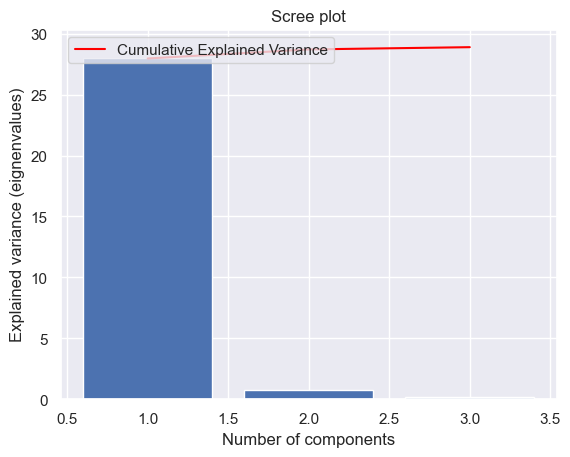

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_matrix)
pca_df = pd.DataFrame(reduced_embeddings)
pca_df["label"] = labels
pca_df["image"] = image
 
# Scree Plot
import numpy as np
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()